In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, auc, RocCurveDisplay
import pandas as pd
import numpy as np
import xgboost
import string
import nltk
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [2]:
colors = ["#D8E8E8", "#A8D0DA", "#406D96", "#2F3A56", "#E2474B"]
sns.set_palette(sns.color_palette(colors))

In [3]:
df = pd.read_csv('../data/preprocessed_train.csv', encoding='utf-8')
df.head()

,title,author,text,label,removed_punc,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide We Didn’t Even See Comey’s Lett...,"['house', 'dem', 'aide', 'we', 'didn’t', 'even...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...",house aide didn’t even comey’s letter jason ch...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,Ever get the feeling your life circles the rou...,"['ever', 'get', 'the', 'feeling', 'your', 'lif...","['ever', 'feeling', 'your', 'life', 'circles',...","['ever', 'feeling', 'life', 'circles', 'rounda...","['ever', 'feeling', 'life', 'circle', 'roundab...",ever feeling life circle roundabout rather hea...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired October 29 2...,"['why', 'the', 'truth', 'might', 'get', 'you',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...",truth might fired october 2016 tension intelli...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Videos 15 Civilians Killed In Single US Airstr...,"['videos', '15', 'civilians', 'killed', 'in', ...","['videos', 'civilians', 'killed', 'single', 'a...","['videos', 'civilians', 'killed', 'single', 'a...","['video', 'civilian', 'killed', 'single', 'air...",video civilian killed single airstrike identif...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Print \nAn Iranian woman has been sentenced to...,"['print', 'an', 'iranian', 'woman', 'has', 'be...","['print', 'iranian', 'woman', 'been', 'sentenc...","['print', 'iranian', 'woman', 'sentenced', 'ye...","['print', 'iranian', 'woman', 'sentenced', 'ye...",print iranian woman sentenced year prison iran...


In [4]:
df = df.dropna()

In [5]:
X = df['clean_text']
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)

In [7]:
X_train.isna().sum()

0

In [8]:
print(X_train.shape)
print(X_test.shape)

(14533,)
(3634,)


In [9]:
X_train

4447     jameson parker election 2016 politics november...
17400    corbett 11222016 month film literature world o...
15251    “…in city king ruled 241200 year flood swept o...
7016     alabama senator jeff session told senate tuesd...
5800     washington obama administration said wednesday...
                               ...                        
745      nteb privacy policy conduct investigation emai...
1041     abby martin expose hillary clinton really repr...
5545     time sport journalist seem getting laid left r...
3062     podestaemails20 wikileaks release another batc...
2931     washington election donald trump mean justice ...
Name: clean_text, Length: 14533, dtype: object

In [10]:
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

print(tfidf_train.toarray())
print(tfidf_train.shape)
print(tfidf_test.toarray())
print(tfidf_test.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(14533, 148708)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3634, 148708)


In [11]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [12]:
def plot_roc_cv(model):
    # Run classifier with cross-validation and plot ROC curves
    cv = KFold(n_splits=5, random_state=42, shuffle=True)


    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(tfidf_train, y_train)):
        model.fit(tfidf_train[train], y_train.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            tfidf_train[test],
            y_train.iloc[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=colors[3],
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        cmap=ListedColormap(colors),
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        # title="ROC Curve",
    )
    ax.legend(loc="lower right")
    plt.show()

## PassiveAggressiveClassifier

In [13]:
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)

pred = pac.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

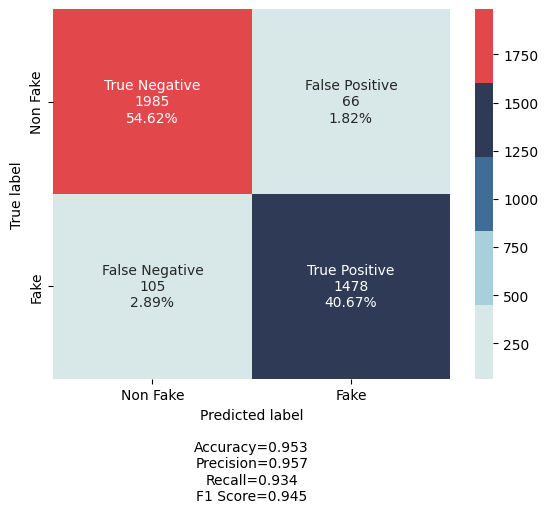

In [14]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

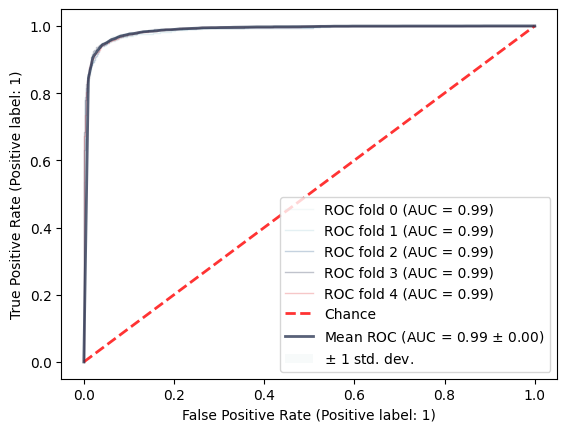

In [15]:
plot_roc_cv(pac)

In [16]:
test_df = pd.read_csv('../data/test.csv', encoding='utf-8')
test_df

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...
5198,25998,300 US Marines To Be Deployed To Russian Borde...,NaN,« Previous - Next » 300 US Marines To Be Deplo...


In [17]:
class Preprocessing:
    def __init__(self, df):
        self._df = df
    
    def _set_dtypes(self):
        self._df['author'][self._df['author'].notna()] = self._df['author'].astype('str')
        self._df['title'][self._df['title'].notna()] = self._df['title'].astype('str')
        self._df['text'][self._df['text'].notna()] = self._df['text'].astype('str')
    
    def _remove_duplicates(self):
        self._df = self._df.drop_duplicates()

    def _remove_empty_rows(self):
        self._df = self._df.dropna(subset=['title', 'author', 'text'])

    def _remove_punctuation(self):
        self._df['removed_punc'] = self._df['text'].apply(lambda x: ("".join([ch for ch in x if ch not in string.punctuation])))

    def _tokenize(self, col_name='removed_punc'):
        # We use the WhitespaceTokenizer to not separate the words with contractions (i.e keep don't, didn't, etc. as one token)
        self._df['tokens'] = self._df[col_name].apply(lambda x: nltk.WhitespaceTokenizer().tokenize(x.lower()))
    
    def _remove_short_words(self, col_name='tokens', min_len=3):
        self._df['filtered_tokens'] = self._df[col_name].apply(lambda x: [word for word in x if len(word) > min_len])

    def _remove_stop_words(self, col_name='filtered_tokens'):
        self._df['clean_tokens'] = self._df[col_name].apply(lambda x: [word for word in x if word not in (nltk.corpus.stopwords.words('english'))])

    def _lemmatize(self, col_name='clean_tokens'):
        self._df['lemma_words'] = self._df[col_name].apply(lambda x : [nltk.WordNetLemmatizer().lemmatize(word) for word in x])

    def _clean_text(self, col_name='lemma_words'):
        self._df['clean_text'] = self._df[col_name].apply(lambda x : " ".join([word for word in x]))

    def preprocess(self):
        # self._set_dtypes()
        self._remove_punctuation()
        self._tokenize()
        self._remove_short_words()
        self._remove_stop_words()
        self._lemmatize()
        self._clean_text()
        
        return self._df

In [18]:
def preprocess(df):
    preprocessing = Preprocessing(df)
    df = preprocessing.preprocess()
    return df

In [19]:
test_df.shape

(5200, 4)

In [20]:
test_df_id = test_df['id']
test_df_id

0       20800
1       20801
2       20802
3       20803
4       20804
        ...  
5195    25995
5196    25996
5197    25997
5198    25998
5199    25999
Name: id, Length: 5200, dtype: int64

In [21]:
test_df = test_df.drop(['title','id','author'],axis=1)
test_df.shape

(5200, 1)

In [22]:
test_df.fillna('fake fake fake',inplace=True)

In [23]:
test_df = preprocess(test_df)
test_df

,text,removed_punc,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,"PALO ALTO, Calif. — After years of scorning...",PALO ALTO Calif — After years of scorning t...,"[palo, alto, calif, —, after, years, of, scorn...","[palo, alto, calif, after, years, scorning, po...","[palo, alto, calif, years, scorning, political...","[palo, alto, calif, year, scorning, political,...",palo alto calif year scorning political proces...
1,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...,"[russian, warships, ready, to, strike, terrori...","[russian, warships, ready, strike, terrorists,...","[russian, warships, ready, strike, terrorists,...","[russian, warship, ready, strike, terrorist, n...",russian warship ready strike terrorist near al...
2,Videos #NoDAPL: Native American Leaders Vow to...,Videos NoDAPL Native American Leaders Vow to S...,"[videos, nodapl, native, american, leaders, vo...","[videos, nodapl, native, american, leaders, st...","[videos, nodapl, native, american, leaders, st...","[video, nodapl, native, american, leader, stay...",video nodapl native american leader stay winte...
3,"If at first you don’t succeed, try a different...",If at first you don’t succeed try a different ...,"[if, at, first, you, don’t, succeed, try, a, d...","[first, don’t, succeed, different, sport, tebo...","[first, don’t, succeed, different, sport, tebo...","[first, don’t, succeed, different, sport, tebo...",first don’t succeed different sport tebow heis...
4,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,42 mins ago 1 Views 0 Comments 0 Likes For the...,"[42, mins, ago, 1, views, 0, comments, 0, like...","[mins, views, comments, likes, first, time, hi...","[mins, views, comments, likes, first, time, hi...","[min, view, comment, like, first, time, histor...",min view comment like first time history we’re...
...,...,...,...,...,...,...,...
5195,Of all the dysfunctions that plague the world’...,Of all the dysfunctions that plague the world’...,"[of, all, the, dysfunctions, that, plague, the...","[dysfunctions, that, plague, world’s, megaciti...","[dysfunctions, plague, world’s, megacities, no...","[dysfunction, plague, world’s, megacities, non...",dysfunction plague world’s megacities none per...
5196,WASHINGTON — Gov. John Kasich of Ohio on Tu...,WASHINGTON — Gov John Kasich of Ohio on Tue...,"[washington, —, gov, john, kasich, of, ohio, o...","[washington, john, kasich, ohio, tuesday, sign...","[washington, john, kasich, ohio, tuesday, sign...","[washington, john, kasich, ohio, tuesday, sign...",washington john kasich ohio tuesday signed abo...
5197,Good morning. (Want to get California Today by...,Good morning Want to get California Today by e...,"[good, morning, want, to, get, california, tod...","[good, morning, want, california, today, email...","[good, morning, want, california, today, email...","[good, morning, want, california, today, email...",good morning want california today email here’...
5198,« Previous - Next » 300 US Marines To Be Deplo...,« Previous Next » 300 US Marines To Be Deploy...,"[«, previous, next, », 300, us, marines, to, b...","[previous, next, marines, deployed, russian, b...","[previous, next, marines, deployed, russian, b...","[previous, next, marine, deployed, russian, bo...",previous next marine deployed russian border n...


In [24]:
test_df['clean_text']

0       palo alto calif year scorning political proces...
1       russian warship ready strike terrorist near al...
2       video nodapl native american leader stay winte...
3       first don’t succeed different sport tebow heis...
4       min view comment like first time history we’re...
                              ...                        
5195    dysfunction plague world’s megacities none per...
5196    washington john kasich ohio tuesday signed abo...
5197    good morning want california today email here’...
5198    previous next marine deployed russian border n...
5199    perhaps you’ve seen series whose pilot episode...
Name: clean_text, Length: 5200, dtype: object

In [25]:
tfidf_test2 = tfidf.transform(test_df['clean_text'])
tfidf_test2.shape

(5200, 148708)

In [26]:
check = pac.predict(tfidf_test2)
check.shape

(5200,)

In [27]:
val = []
for i in check:
    val.append(i)

In [28]:
submission = pd.DataFrame({'id': test_df_id, 'label':val})
submission

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,1
5196,25996,0
5197,25997,0
5198,25998,1


In [29]:
submission.to_csv('submission.csv',index=False)

## LogisticRegression

In [30]:
lr = LogisticRegression(max_iter = 500)
lr.fit(tfidf_train, y_train)

pred = lr.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

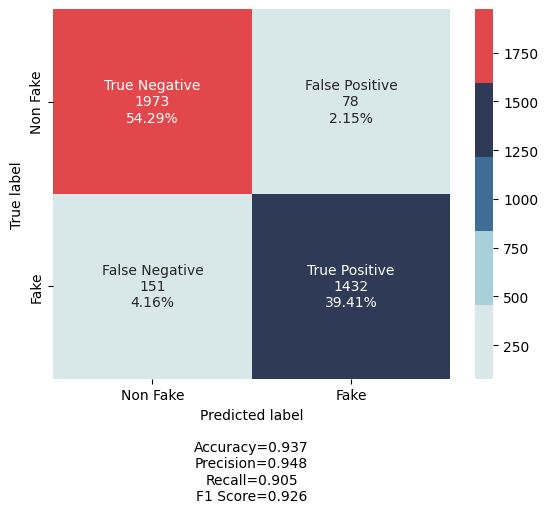

In [31]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

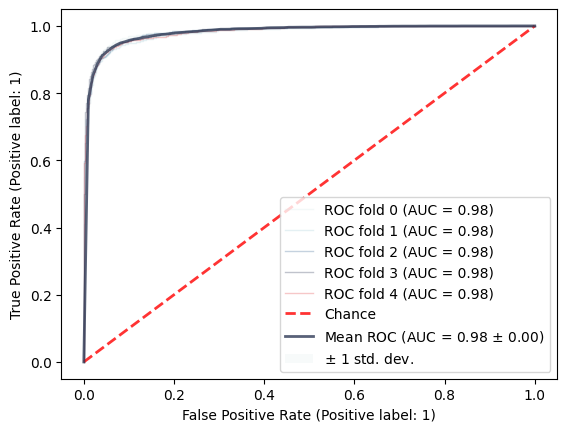

In [32]:
plot_roc_cv(lr)

## XGBClassifier

In [33]:
xgb = XGBClassifier()
xgb.fit(tfidf_train, y_train)

pred = xgb.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


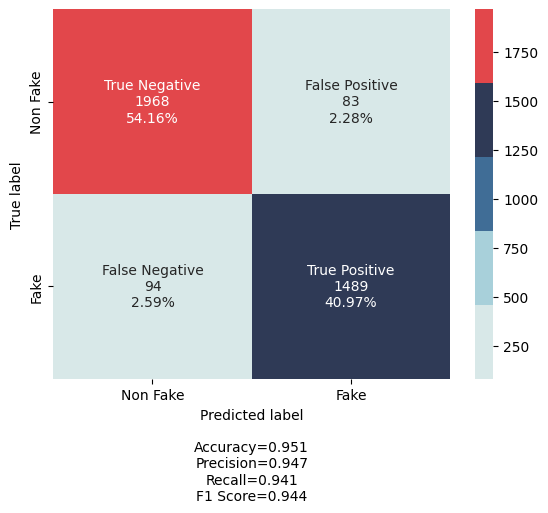

In [34]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, 

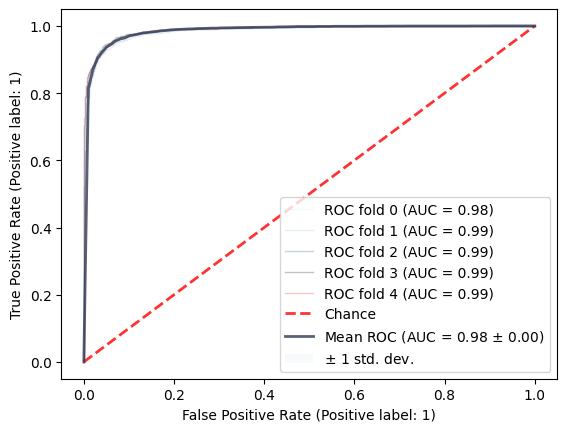

In [35]:
plot_roc_cv(xgb)

## LGBMClassifier

In [36]:
lgbm = LGBMClassifier()
lgbm.fit(tfidf_train, y_train)

pred = lgbm.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

[LightGBM] [Info] Number of positive: 6224, number of negative: 8309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.622845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 867709
[LightGBM] [Info] Number of data points in the train set: 14533, number of used features: 16372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428267 -> initscore=-0.288926
[LightGBM] [Info] Start training from score -0.288926


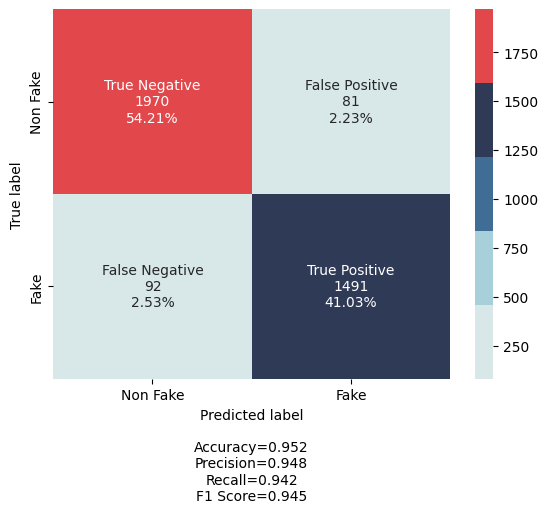

In [37]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

[LightGBM] [Info] Number of positive: 4977, number of negative: 6649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.436327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732429
[LightGBM] [Info] Number of data points in the train set: 11626, number of used features: 14445
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428092 -> initscore=-0.289639
[LightGBM] [Info] Start training from score -0.289639
[LightGBM] [Info] Number of positive: 4965, number of negative: 6661
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.425576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730030
[LightGBM] [Info] Number of data points in the train set: 11626, number of used features: 14383
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427060 -> initscore=-0.293

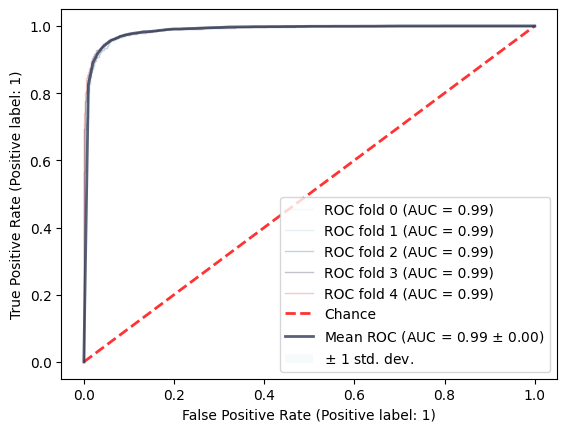

In [38]:
plot_roc_cv(lgbm)

# Title vs clean_text metrics

In [39]:
title_metrics = {
    'LogisticRegression': {
        'Accuracy': 0.917,
        'Precision': 0.854,
        'Recall': 0.977,
        'F1 Score': 0.912
    },
    'PassiveAggressiveClassifier': {
        'Accuracy': 0.933,
        'Precision': 0.911,
        'Recall': 0.937,
        'F1 Score': 0.924
    },
    'LGBMClassifier': {
        'Accuracy': 0.922,
        'Precision': 0.872,
        'Recall': 0.962,
        'F1 Score': 0.915
    },
    'XGBClassifier': {
        'Accuracy': 0.923,
        'Precision': 0.862,
        'Recall': 0.979,
        'F1 Score': 0.917
    }
}

In [40]:
df_title = pd.DataFrame.from_dict({(i, j): title_metrics[i][j] for i in title_metrics.keys() for j in title_metrics[i].keys()}, orient='index')
df_title.index = pd.MultiIndex.from_tuples(df.index, names=['Model', 'Metric'])
df_title.columns = ['Value']
df_title

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

In [ ]:
clean_text_metrics = {
    'LogisticRegression': {
        'Accuracy': 0.937,
        'Precision': 0.948,
        'Recall': 0.905,
        'F1 Score': 0.926
    },
    'PassiveAggressiveClassifier': {
        'Accuracy': 0.953,
        'Precision': 0.959,
        'Recall': 0.933,
        'F1 Score': 0.946
    },
    'LGBMClassifier': {
        'Accuracy': 0.952,
        'Precision': 0.948,
        'Recall': 0.942,
        'F1 Score': 0.945
    },
    'XGBClassifier': {
        'Accuracy': 0.951,
        'Precision': 0.947,
        'Recall': 0.941,
        'F1 Score': 0.944
    }
}

In [ ]:
df_clean_text = pd.DataFrame.from_dict({(i, j): clean_text_metrics[i][j] for i in clean_text_metrics.keys() for j in clean_text_metrics[i].keys()}, orient='index')
df_clean_text.index = pd.MultiIndex.from_tuples(df.index, names=['Model', 'Metric'])
df_clean_text.columns = ['Value']
df_clean_text

Value
Model                       Metric          
LogisticRegression          Accuracy   0.937
                            Precision  0.948
                            Recall     0.905
                            F1 Score   0.926
PassiveAggressiveClassifier Accuracy   0.953
                            Precision  0.959
                            Recall     0.933
                            F1 Score   0.946
LGBMClassifier              Accuracy   0.952
                            Precision  0.948
                            Recall     0.942
                            F1 Score   0.945
XGBClassifier               Accuracy   0.951
                            Precision  0.947
                            Recall     0.941
                            F1 Score   0.944

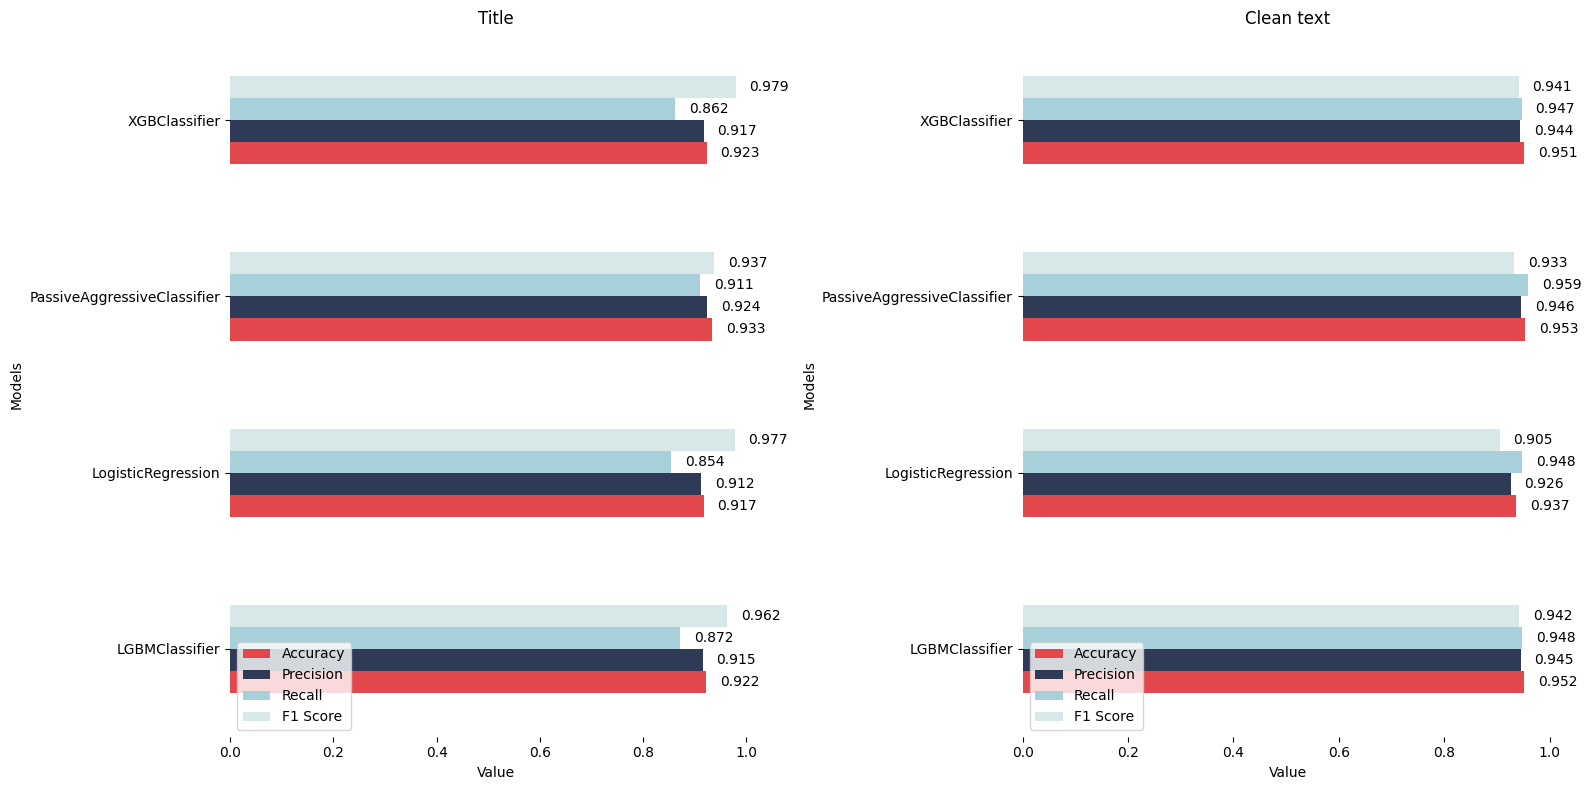

In [ ]:
# Configurar el tamaño y diseño de los subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Primer subplot para el análisis de títulos
df_title_unstacked = df_title.unstack(level='Model')
df_title_unstacked.columns = df_title_unstacked.columns.droplevel()
df_title_unstacked = df_title_unstacked.transpose()
ax = df_title_unstacked.plot(kind='barh', stacked=False, colormap=ListedColormap(colors[::-1]), ax=axes[0])

for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(10, 0), textcoords='offset points')



# Configurar el título y las etiquetas del primer subplot
axes[0].set_title('Title')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Models')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].legend(df_title.index.get_level_values(1).unique(), loc='lower left')

# Segundo subplot para el análisis de contenido
df_clean_text_unstacked = df_clean_text.unstack(level='Model')
df_clean_text_unstacked.columns = df_clean_text_unstacked.columns.droplevel()
df_clean_text_unstacked = df_clean_text_unstacked.transpose()
ax = df_clean_text_unstacked.plot(kind='barh', stacked=False, colormap=ListedColormap(colors[::-1]), ax=axes[1])

for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(10, 0), textcoords='offset points')



# Configurar el título y las etiquetas del segundo subplot
axes[1].set_title('Clean text')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Models')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].legend(df_clean_text.index.get_level_values(1).unique(), loc='lower left')

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()
# Mostrar los subplots
plt.show()